In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the CSV file (already done in your code)
#--stepwise
csv_path = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/2 Generation Expansion Model/5 Dispatch Curve/3 Intemediate Results [if any]/1 Comprehensive Results Samples/Hourly_Results_NE_stepwise_2024_11_30_2324_pathway_B1_iteration_1.csv"
hourly_results = pd.read_csv(csv_path)

csv_path = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/2 Generation Expansion Model/5 Dispatch Curve/4 Final Results/1 Comprehensive Days Summary Results/Yearly_Results.csv"
yearly_results = pd.read_csv(csv_path)

#--rep days
#csv_path = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/2 Generation Expansion Model/5 Dispatch Curve/4 Final Results/2 Representative Days Summary Results/Yearly_Results_rep_days.csv"
#yearly_results = pd.read_csv(csv_path)

#csv_path = "/Users/amirgazar/Documents/GitHub/EPA_Debarbonization/2 Generation Expansion Model/5 Dispatch Curve/3 Intemediate Results [if any]/2 Representative Results Samples/Hourly_Results_NE_rep_days.csv"
#hourly_results = pd.read_csv(csv_path)


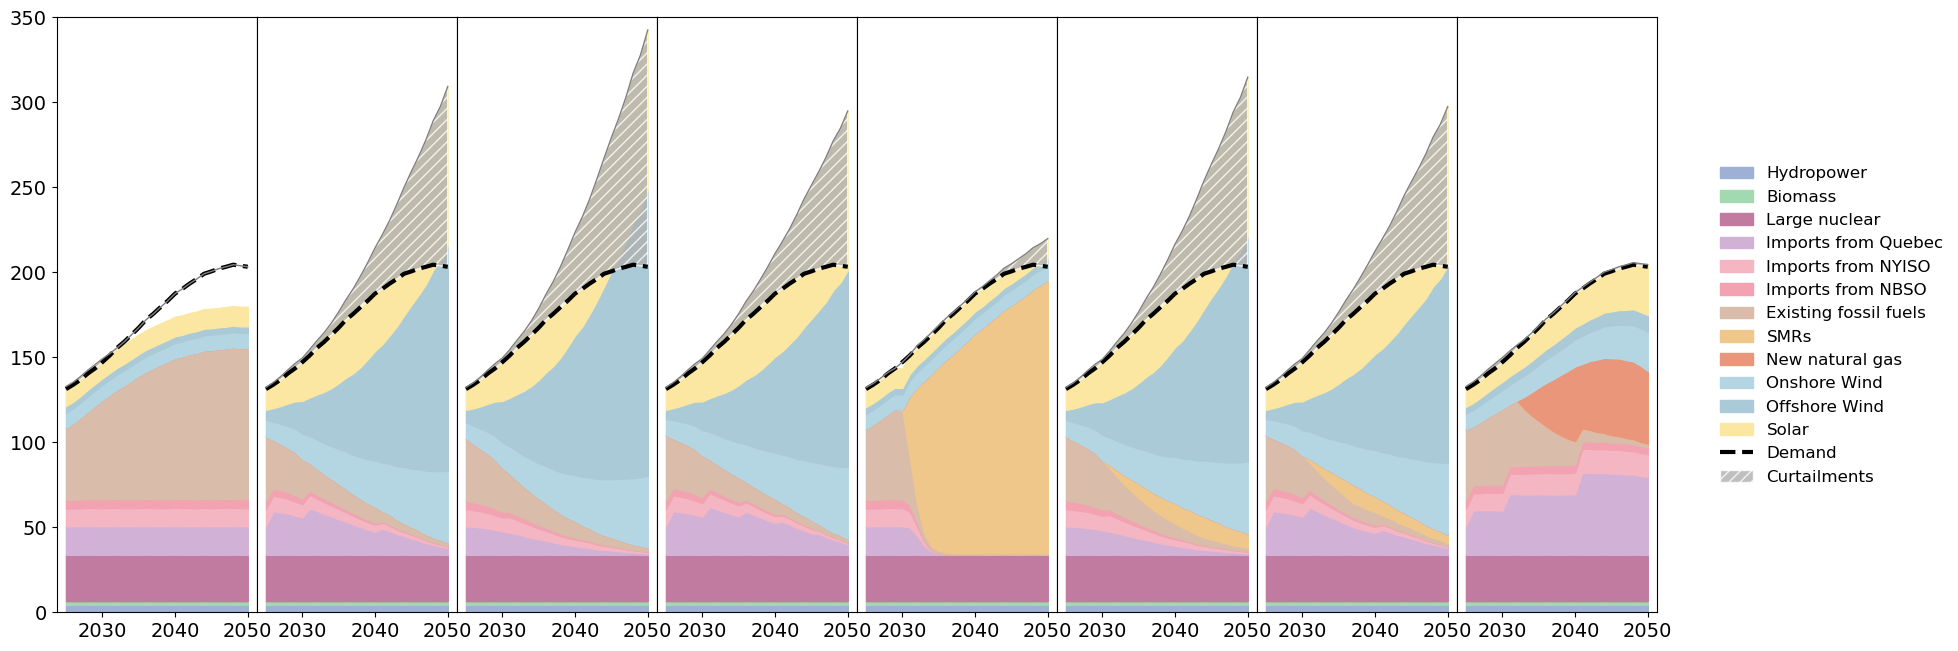

In [17]:
# Define color scheme
colors = {
    "Existing fossil fuels": "#D9BCA9",
    "New natural gas": "#E9967A",
    "Large nuclear": "#C27BA0",
    "SMRs": "#F0C78A",
    "Hydropower": "#9EB1D4",
    "Biomass": "#A2D9B1",
    "Imports from Quebec": "#D1B1D6",
    "Imports from NYISO": "#F4B6C2",
    "Imports from NBSO": "#F2A2B0",
    "Solar": "#FBE7A1",
    "Onshore Wind": "#B4D6E3",
    "Offshore Wind": "#A9CAD6"
}

# Columns in the order to stack
columns_ordered = ['Hydropower', 'Biomass','Large nuclear',   'Imports from Quebec',
                   'Imports from NYISO', 'Imports from NBSO','Existing fossil fuels', 'SMRs', 'New natural gas',
                   'Onshore Wind', 'Offshore Wind', 'Solar']

# Legend mapping
legend_names = {
    'Nuclear.gen_hr_TWh': 'Large nuclear',
    'Hydro.gen_hr_TWh': 'Hydropower',
    'Bio.gen_hr_TWh': 'Biomass',
    'Fossil_old.gen_hr_TWh': 'Existing fossil fuels',
    'Import.QC_hr_TWh': 'Imports from Quebec',
    'Import.NYISO_hr_TWh': 'Imports from NYISO',
    'Import.NB_hr_TWh': 'Imports from NBSO',
    'Onwind.gen_hr_TWh': 'Onshore Wind',
    'Offwind.gen_hr_TWh': 'Offshore Wind',
    'Solar.gen_hr_TWh': 'Solar',
    'SMR.gen_hr_TWh': 'SMRs',
    'Fossil_new.gen_hr_TWh': 'New natural gas'
}


# Pivot the data for easier plotting
melted = yearly_results.melt(id_vars=['Year', 'Pathway'], 
                             value_vars=list(legend_names.keys()), 
                             var_name='Source', value_name='Generation')

melted['Source'] = melted['Source'].map(legend_names)

# Filter only numeric columns for the mean calculation
mean_summary = melted.groupby(['Year', 'Pathway', 'Source']).agg({'Generation': 'mean'}).reset_index()

# Updated Plotting
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20, 7), gridspec_kw={'hspace': 0.2, 'wspace': 0})

plt.rcParams.update({'font.size': 14})

# Function to plot each pathway
def plot_pathway(ax, data, pathway, demand_data, show_y_axis):
    bottom = np.zeros(len(data['Year'].unique()))
    for source in columns_ordered:
        subset = data[data['Source'] == source]
        subset = subset.set_index('Year').reindex(data['Year'].unique()).reset_index()
        ax.fill_between(subset['Year'], bottom, bottom + subset['Generation'], label=source, color=colors[source])
        bottom += subset['Generation']
    
    # Aggregate demand data to ensure a single line per year
    demand_data_agg = demand_data.groupby('Year')['Demand.total_hr_TWh'].mean().reset_index()
    gen_data_agg = demand_data.groupby('Year')['Total.gen_hr_TWh'].mean().reset_index()
    imports_data_agg = demand_data.groupby('Year')['Imports.total_hr_TWh'].mean().reset_index()
    
    # Merge aggregated data into a single DataFrame
    curtailments = demand_data_agg.copy()
    curtailments = curtailments.merge(gen_data_agg, on='Year')
    curtailments = curtailments.merge(imports_data_agg, on='Year')
    
    # Calculate Curtailments
    curtailments['Curtailments'] = (
        curtailments['Imports.total_hr_TWh'] +
        curtailments['Total.gen_hr_TWh'] -
        curtailments['Demand.total_hr_TWh']
    )
    
    # Filter only positive curtailments
    curtailments['Curtailments'] = curtailments['Curtailments'].apply(lambda x: x if x > 0 else 0)
    curtailments['Curtailments'] = curtailments['Demand.total_hr_TWh'] + curtailments['Curtailments']

    # Plot Demand as a solid line
    ax.plot(demand_data_agg['Year'], demand_data_agg['Demand.total_hr_TWh'], color='black', linestyle='--', linewidth=3, label='Demand')
    
    # Plot Curtailments (Demand + Excess Clean Generation) as a dashed line
    ax.plot(curtailments['Year'], curtailments['Curtailments'], color='grey', linestyle='-', linewidth=1)

    # Fill the area between Curtailments and Demand
    ax.fill_between(curtailments['Year'], demand_data_agg['Demand.total_hr_TWh'], curtailments['Curtailments'], color='#B0B0B0', alpha=0.8, edgecolor="white", hatch="///", label='Curtailments')

    #ax.set_title(pathway, fontsize=16, pad=10)
    ax.set_ylim(0, 350)

    if show_y_axis:
        #ax.set_ylabel('Generation (TWh)', fontsize=14)
        ax.set_ylabel('', fontsize=14)
    else:
        ax.set_yticks([])  # Hide y-axis for other plots in the row

# Filter data for each pathway and plot
pathways = sorted(yearly_results["Pathway"].unique())

# Collect handles and labels for the unified legend
all_handles, all_labels = [], []

for i in range(8):
    data = mean_summary[mean_summary['Pathway'] == pathways[i]]
    demand_data = yearly_results[yearly_results['Pathway'] == pathways[i]]
    show_y_axis = (i == 0)  # Show y-axis only for the first plot
    plot_pathway(axes[i], data, pathways[i], demand_data, show_y_axis)

# Add a unified legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', fontsize=12, frameon=False)

plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.1)

# Save the figure
plt.savefig('Generation_Pathways.svg', dpi=300, bbox_inches='tight')

plt.show()


In [18]:
columns_ordered = ['Hydropower', 'Biomass','Large nuclear',   'Imports from Quebec',
                   'Imports from NYISO', 'Imports from NBSO','Existing fossil fuels', 'SMRs', 'New natural gas',
                   'Onshore Wind', 'Offshore Wind', 'Solar']

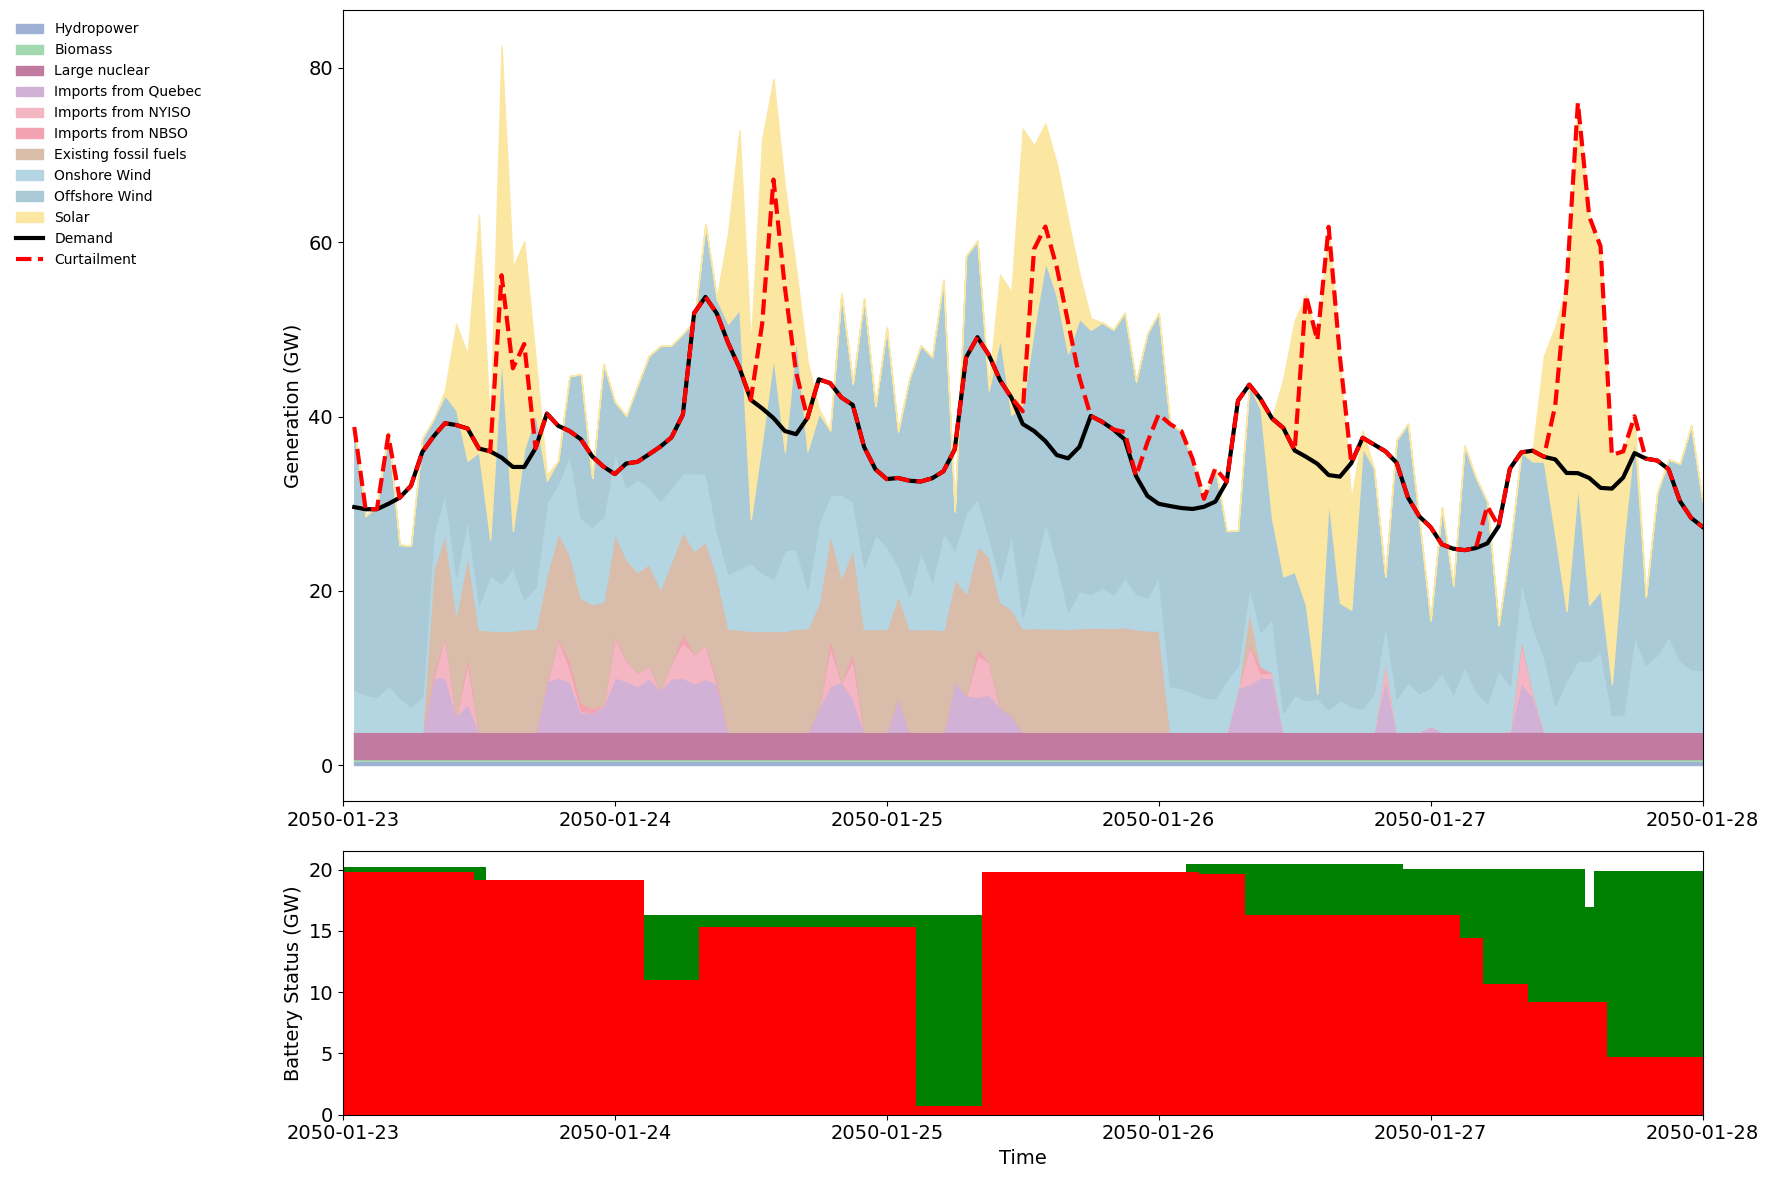

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to filter and summarize data for a given date range
def summarize_data_for_date(df, start_date, end_date):
    df['Date'] = pd.to_datetime(df['Date'])
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    
    hourly_summary = df_filtered.groupby(['Date', 'Hour']).agg({
        'Solar.gen_hr_MW': 'mean',
        'Onwind.gen_hr_MW': 'mean',
        'Offwind.gen_hr_MW': 'mean',
        'Nuclear.gen_hr_MW': 'mean',
        'SMR.gen_hr_MW': 'mean',
        'Hydro.gen_hr_MW': 'mean',
        'Bio.gen_hr_MW': 'mean',
        'Fossil_old.gen_hr_MW': 'mean',
        'Fossil_new.gen_hr_MW': 'mean',
        'Import.QC_hr_MW': 'mean',
        'Import.NYISO_hr_MW': 'mean',
        'Import.NB_hr_MW': 'mean',
        'Imports.total_hr_MW': 'mean',
        'Storage.status_hr_MW': 'mean',
        'Storage.charging_hours': 'max',
        'Storage.discharging_hours': 'max',
        'Demand.total_hr_MW': 'mean',
        'ExcessClean.gen_hr_MW': 'mean',
        'Total.gen_hr_MW': 'mean'
    }).reset_index()

    hourly_summary['Storage.charging_hours'] = hourly_summary['Storage.charging_hours'].astype(int)
    hourly_summary['Storage.discharging_hours'] = hourly_summary['Storage.discharging_hours'].astype(int)
    hourly_summary['Battery_Charging'] = hourly_summary['Storage.status_hr_MW'] * hourly_summary['Storage.charging_hours']
    hourly_summary['Battery_Discharging'] = hourly_summary['Storage.status_hr_MW'] * hourly_summary['Storage.discharging_hours']
    
    columns_to_convert = [
        'Solar.gen_hr_MW', 'Onwind.gen_hr_MW', 'Offwind.gen_hr_MW', 'Nuclear.gen_hr_MW',
        'SMR.gen_hr_MW', 'Hydro.gen_hr_MW', 'Bio.gen_hr_MW', 'Fossil_old.gen_hr_MW',
        'Fossil_new.gen_hr_MW', 'Import.QC_hr_MW', 'Import.NYISO_hr_MW', 'Import.NB_hr_MW',
        'Imports.total_hr_MW', 'Total.gen_hr_MW',
        'Demand.total_hr_MW', 'Battery_Charging', 'Battery_Discharging', 'ExcessClean.gen_hr_MW'
    ]
    
    for column in columns_to_convert:
        hourly_summary[column] = hourly_summary[column] / 1000.0
    
    # Combine Date and Hour into a single sequential datetime index
    hourly_summary['Datetime'] = pd.to_datetime(hourly_summary['Date']) + pd.to_timedelta(hourly_summary['Hour'], unit='h')
    return hourly_summary

# Legend names and their mapping to columns
legend_mapping = {
    'Hydro.gen_hr_MW': 'Hydropower',
    'Bio.gen_hr_MW': 'Biomass',
    'Nuclear.gen_hr_MW': 'Large nuclear',
    'Import.QC_hr_MW': 'Imports from Quebec',
    'Import.NYISO_hr_MW': 'Imports from NYISO',
    'Import.NB_hr_MW': 'Imports from NBSO',
    'Fossil_old.gen_hr_MW': 'Existing fossil fuels',
    'SMR.gen_hr_MW': 'SMRs',
    'Fossil_new.gen_hr_MW': 'New natural gas',
    'Onwind.gen_hr_MW': 'Onshore Wind',
    'Offwind.gen_hr_MW': 'Offshore Wind',
    'Solar.gen_hr_MW': 'Solar',
}

columns_ordered = list(legend_mapping.keys())

colors = {
    'Hydro.gen_hr_MW': '#9EB1D4',
    'Bio.gen_hr_MW': '#A2D9B1',
    'Nuclear.gen_hr_MW': '#C27BA0',
    'Import.QC_hr_MW': '#D1B1D6',
    'Import.NYISO_hr_MW': '#F4B6C2',
    'Import.NB_hr_MW': '#F2A2B0',
    'Fossil_old.gen_hr_MW': '#D9BCA9',
    'SMR.gen_hr_MW': '#F0C78A',
    'Fossil_new.gen_hr_MW': '#E9967A',
    'Onwind.gen_hr_MW': '#B4D6E3',
    'Offwind.gen_hr_MW': '#A9CAD6',
    'Solar.gen_hr_MW': '#FBE7A1',
}

def plot_pathway_data(pathway_data, start_date, end_date):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1]})
    main_ax, battery_ax = axes

    x = pathway_data['Datetime']
    bottom = np.zeros(len(x))

    # Filter sources with non-zero values
    active_sources = [col for col in columns_ordered if pathway_data[col].sum() > 0]

    for source in active_sources:
        main_ax.fill_between(
            x,
            bottom,
            bottom + pathway_data[source],
            label=legend_mapping[source],
            color=colors[source]
        )
        bottom += pathway_data[source]

    main_ax.plot(
        x, pathway_data['Demand.total_hr_MW'],
        linestyle='-', linewidth=3, color='black', label='Demand'
    )

    if 'ExcessClean.gen_hr_MW' in pathway_data.columns:
        main_ax.plot(
            x, pathway_data['Demand.total_hr_MW'] + pathway_data['ExcessClean.gen_hr_MW'],
            linestyle='--', linewidth=3, color='red', label='Curtailment'
        )

    battery_ax.bar(x, pathway_data['Battery_Charging'], color='green', label='Battery Charging')
    battery_ax.bar(x, pathway_data['Battery_Discharging'], color='red', label='Battery Discharging')

    main_ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    main_ax.legend(
        loc='upper left', 
        bbox_to_anchor=(-0.25, 1), 
        fontsize=10, 
        frameon=False
    )
    main_ax.set_ylabel("Generation (GW)")

    battery_ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    battery_ax.set_ylabel("Battery Status (GW)")
    battery_ax.set_xlabel("Time")

    plt.tight_layout()
    plt.show()

# Weekly plot
start_date = "2050-01-23"
end_date = "2050-01-27"

hourly_summary = summarize_data_for_date(hourly_results, start_date, end_date)
plot_pathway_data(hourly_summary, start_date, end_date)


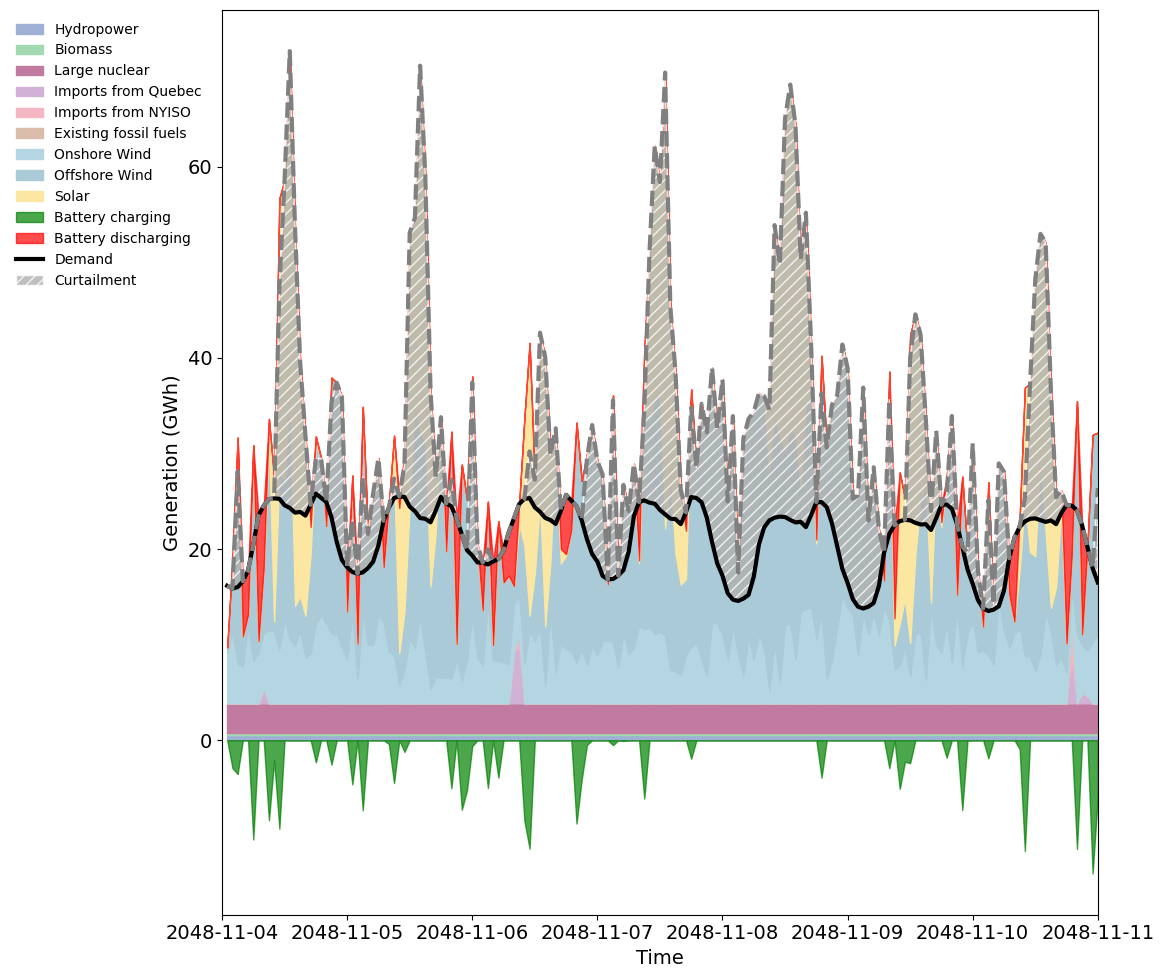

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_pathway_data(pathway_data, start_date, end_date):
    # Calculate battery difference (lag) in GWh
    pathway_data['Battery_Difference'] = pathway_data['Storage.status_hr_MW'].diff().fillna(0) / 1000

    fig, ax = plt.subplots(figsize=(12, 10))

    x = pathway_data['Datetime']
    bottom = np.zeros(len(x))

    # Filter sources with non-zero values
    active_sources = [col for col in columns_ordered if pathway_data[col].sum() > 0]

    # Stack all sources for generation
    for source in active_sources:
        ax.fill_between(
            x,
            bottom,
            bottom + pathway_data[source],
            label=legend_mapping[source],
            color=colors[source]
        )
        bottom += pathway_data[source]

    # Add battery charging (green) below the plot, starting from zero
    battery_charge = pathway_data['Battery_Difference'].where(pathway_data['Battery_Difference'] > 0, 0)
    ax.fill_between(
        x,
        0,
        -battery_charge,
        label='Battery charging',
        color='green',
        alpha=0.7
    )

    # Add battery discharging (red) on top of all generation stacks
    battery_discharge = pathway_data['Battery_Difference'].where(pathway_data['Battery_Difference'] < 0, 0)
    ax.fill_between(
        x,
        bottom,
        bottom + battery_discharge.abs(),
        label='Battery discharging',
        color='red',
        alpha=0.7
    )

    # Add demand curve
    ax.plot(
        x, pathway_data['Demand.total_hr_MW'],
        linestyle='-', linewidth=3, color='black', label='Demand'
    )
    

    pathway_data['Curtailments'] = (
        pathway_data['Imports.total_hr_MW'] +
        pathway_data['Total.gen_hr_MW'] -
        pathway_data['Demand.total_hr_MW'] - (battery_charge))
    # Set curtailments to zero if generation + imports is below demand
    pathway_data['Curtailments'] = pathway_data['Curtailments'].apply(lambda x: max(x, 0))

    # Add curtailment if available
    if 'ExcessClean.gen_hr_MW' in pathway_data.columns:
        # Plot the line for the sum
        ax.plot(
            x, 
            pathway_data['Demand.total_hr_MW'] + pathway_data['Curtailments'],
            linestyle='--', 
            linewidth=3, 
            color='grey'
        )
        
        # Add the shaded area between demand and the sum
        ax.fill_between(
            x, 
            pathway_data['Demand.total_hr_MW'], 
            pathway_data['Demand.total_hr_MW'] + pathway_data['Curtailments'],  
            color='#B0B0B0', alpha=0.8, edgecolor="white", hatch="///",
            label='Curtailment'
        )
        


    # Configure the plot
    ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    ax.legend(
        loc='upper left', 
        bbox_to_anchor=(-0.25, 1), 
        fontsize=10, 
        frameon=False
    )
    ax.set_ylabel("Generation (GWh)")
    ax.set_xlabel("Time")
    plt.tight_layout()
    plt.savefig('Sample_week_comp_B1_sim1.svg', dpi=300, bbox_inches='tight')
    plt.show()

# Weekly plot
start_date = "2050-01-23"
end_date = "2050-01-27"

start_date = "2048-11-04"
end_date = "2048-11-10"

hourly_summary = summarize_data_for_date(hourly_results, start_date, end_date)
plot_pathway_data(hourly_summary, start_date, end_date)


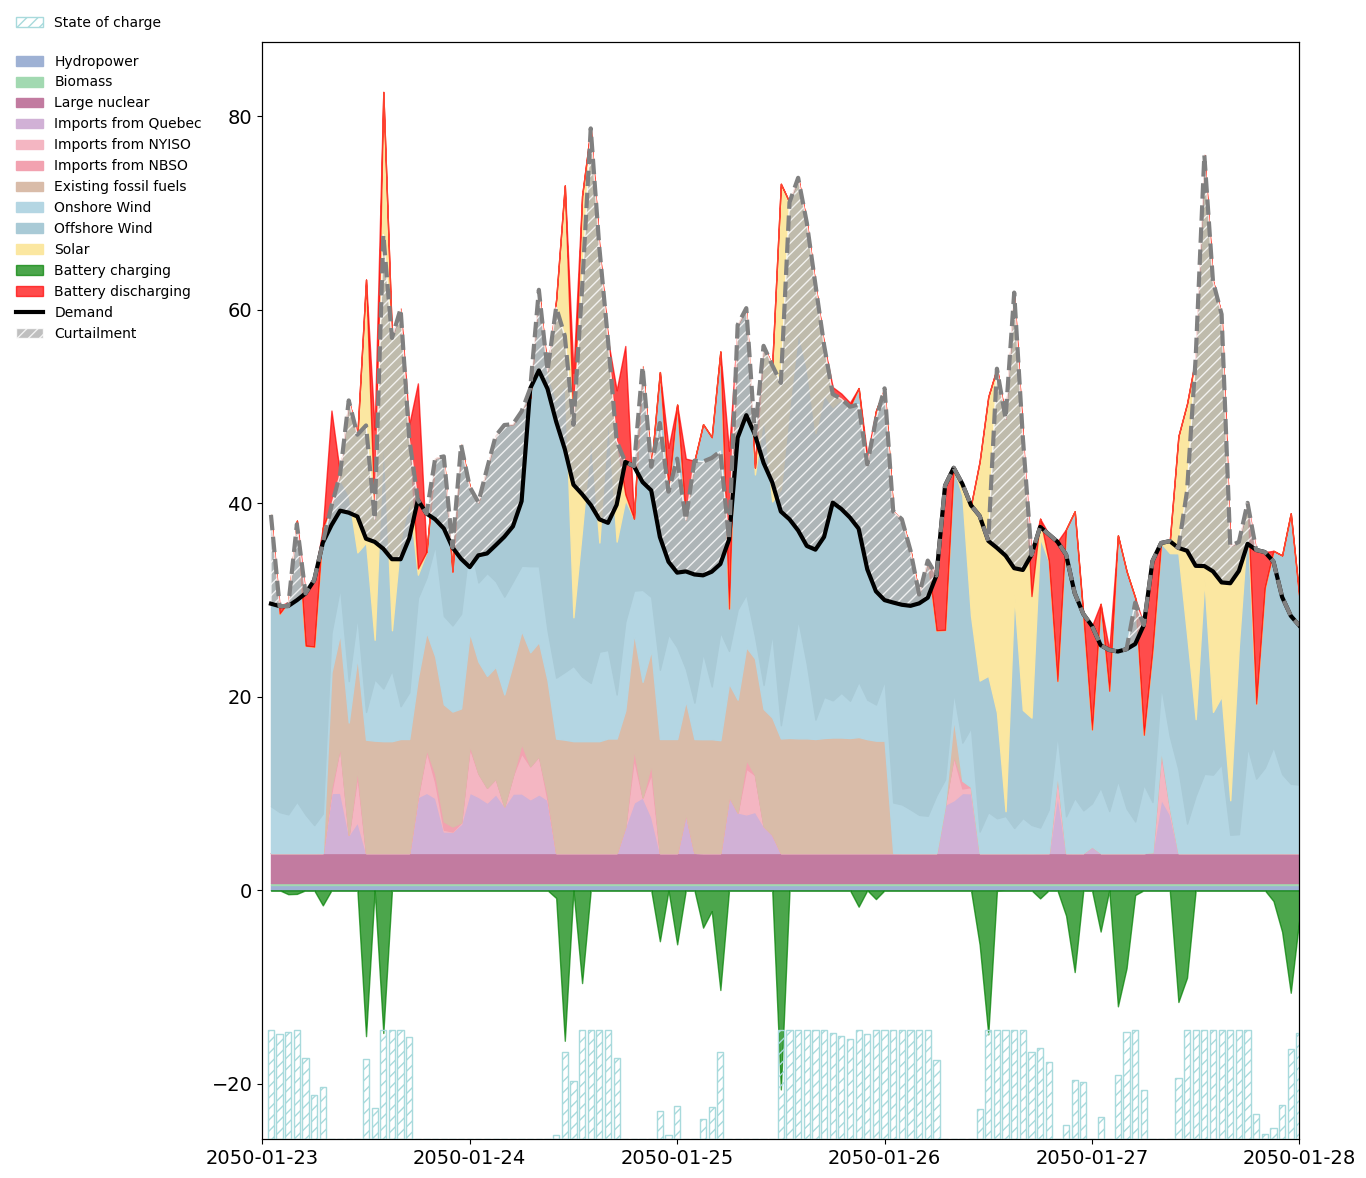

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_pathway_data(pathway_data, start_date, end_date):
    # Calculate battery difference (lag) in GWh
    pathway_data['Battery_Difference'] = pathway_data['Storage.status_hr_MW'].diff().fillna(0) / 1000
    
    # Extract year from start_date
    year_of_interest = pd.to_datetime(start_date).year
    max_storage_status = pathway_data[pathway_data['Datetime'].dt.year == year_of_interest]['Storage.status_hr_MW'].max()
    
    # Calculate State of Charge
    pathway_data['State_of_Charge'] = pathway_data['Storage.status_hr_MW'] * 100/ max_storage_status

    fig, ax = plt.subplots(figsize=(14, 12))

    x = pathway_data['Datetime']
    bottom = np.zeros(len(x))

    # Filter sources with non-zero values
    active_sources = [col for col in columns_ordered if pathway_data[col].sum() > 0]

    # Stack all sources for generation
    for source in active_sources:
        ax.fill_between(
            x,
            bottom,
            bottom + pathway_data[source],
            label=legend_mapping[source],
            color=colors[source]
        )
        bottom += pathway_data[source]

    # Add battery charging (green) below the plot, starting from zero
    battery_charge = pathway_data['Battery_Difference'].where(pathway_data['Battery_Difference'] > 0, 0)
    ax.fill_between(
        x,
        0,
        -battery_charge,
        label='Battery charging',
        color='green',
        alpha=0.7
    )

    # Add battery discharging (red) on top of all generation stacks
    battery_discharge = pathway_data['Battery_Difference'].where(pathway_data['Battery_Difference'] < 0, 0)
    ax.fill_between(
        x,
        bottom,
        bottom + battery_discharge.abs(),
        label='Battery discharging',
        color='red',
        alpha=0.7
    )

    # Add demand curve
    ax.plot(
        x, pathway_data['Demand.total_hr_MW'],
        linestyle='-', linewidth=3, color='black', label='Demand'
    )
    

    pathway_data['Curtailments'] = (
        pathway_data['Imports.total_hr_MW'] +
        pathway_data['Total.gen_hr_MW'] -
        pathway_data['Demand.total_hr_MW'] - (battery_charge))
    # Set curtailments to zero if generation + imports is below demand
    pathway_data['Curtailments'] = pathway_data['Curtailments'].apply(lambda x: max(x, 0))

    # Add curtailment if available
    if 'ExcessClean.gen_hr_MW' in pathway_data.columns:
        # Plot the line for the sum
        ax.plot(
            x, 
            pathway_data['Demand.total_hr_MW'] + pathway_data['Curtailments'],
            linestyle='--', 
            linewidth=3, 
            color='grey'
        )
        
        # Add the shaded area between demand and the sum
        ax.fill_between(
            x, 
            pathway_data['Demand.total_hr_MW'], 
            pathway_data['Demand.total_hr_MW'] + pathway_data['Curtailments'],  
            color='#B0B0B0', alpha=0.8, edgecolor="white", hatch="///",
            label='Curtailment'
        )
        
    # Add State of Charge bar chart on the secondary Y-axis
    ax2 = ax.twinx()
    
    # Scale SoC values to fit within the smaller range
    scaled_soc_values = pathway_data['State_of_Charge'] / 10  # Shrinks range from 0-100 to 0-20
    
    # Plot the SoC as a bar chart
    ax2.bar(
        x, scaled_soc_values,
        width=0.03,  # Adjust bar width for aesthetics
        color='none', edgecolor='#A8DADC', label='State of charge', hatch='///'
    )
    
    # Set secondary Y-axis label and limits
    ax2.set_ylim(0, 100)  # Smaller Y-axis range
    ax2.set_yticks([])  # Remove ticks
    ax2.set_yticklabels([])  # Remove tick labels
    ax2.legend(
        loc='lower left', 
        bbox_to_anchor=(-0.25, 1), 
        fontsize=10, 
        frameon=False
    )
    #ax2.spines['right'].set_color('#A8DADC')  # Set the color of the axis spine

    # Configure the plot
    ax.set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date) + pd.Timedelta(days=1))
    ax.legend(
        loc='upper left', 
        bbox_to_anchor=(-0.25, 1), 
        fontsize=10, 
        frameon=False
    )
    #ax.set_ylabel("Generation (GWh)")
    #ax.set_xlabel("Time")
    plt.tight_layout()
    plt.savefig('Sample_week_comp_B1_sim1.svg', dpi=300, bbox_inches='tight')
    plt.show()

# Weekly plot
start_date = "2050-01-23"
end_date = "2050-01-27"

#start_date = "2048-11-04"
#end_date = "2048-11-10"

filtered_results = hourly_results[hourly_results['Pathway'] == 'B1']

hourly_summary = summarize_data_for_date(filtered_results, start_date, end_date)
plot_pathway_data(hourly_summary, start_date, end_date)
